In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # one-hot-encoding方法
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

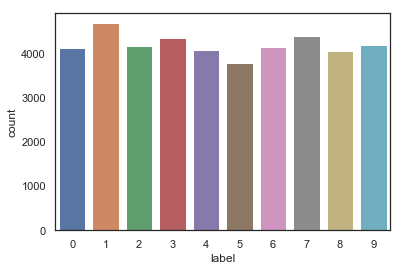

In [6]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

# 释放空间
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()#对训练集标签进行统计

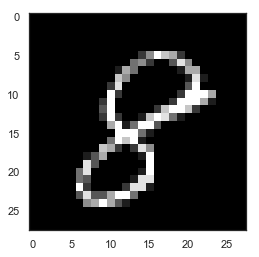

In [7]:
X_train = X_train / 255.0
test = test / 255.0
#将每一个样本，即784个值的一维向量重塑为28*28*1的三维向量，表示一个通道的大小为28*28的图片
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

random_seed = 2
#划分训练集及交叉验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
g = plt.imshow(X_train[0][:,:,0], cmap = 'gray')

In [8]:
#卷积神经网络模型的建立
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [9]:
#使用RMSprop优化器
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# categorical_crossentropy多分类损失函数 使用accuracy评估模型性能
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [11]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 3 
batch_size = 86

In [12]:
#数据增广
#随机旋转一些训练图像10度
#随机缩放10%个训练图像
#随机地将图像按宽度的10%移位
#随机将图像垂直移动10%的高度
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  


datagen.fit(X_train)

In [13]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/3
 - 190s - loss: 0.4203 - acc: 0.8675 - val_loss: 0.0816 - val_acc: 0.9745
Epoch 2/3
 - 188s - loss: 0.1369 - acc: 0.9594 - val_loss: 0.0425 - val_acc: 0.9867
Epoch 3/3
 - 193s - loss: 0.1052 - acc: 0.9695 - val_loss: 0.0355 - val_acc: 0.9886


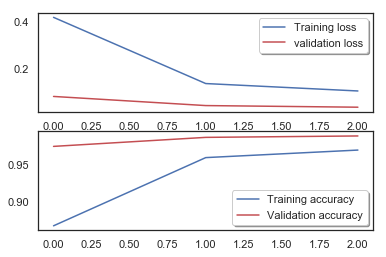

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

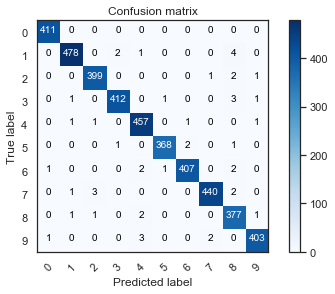

In [15]:
#定义计算混淆矩阵的函数
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 利用交叉验证集进行评估
Y_pred = model.predict(X_val)
 #将输出转换为one hot向量
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_val,axis = 1) 
# 计算混淆矩阵
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
#绘出混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [16]:
#预测测试集
#结果输出为csv文件

results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)